## Idealized Surface Soil Moisture Bucket Model or SWAP (Soil, Water, Atmosphere and Plant) Model
Developed as coursework

### Governing Equation

In imagining the regions soil moisture as a large bucket, the governing equation can be simplified to: 

### $\frac{dS}{dt} = P - (\beta E_{pot})$

where $\frac{dS}{dt}$ is the change in surface soil water content (soil moisture in mm), P is precipitation (mm/month), $\beta$ is a scaling factor representing soil moisture content's impact on plant transpiration, $E_{pot}$ is potential evapotranspiration (mm/day converted to mm/month).

Precipitation is variable and pulled from an observational data product, CRU (more on that below). R and D are constants. 

Evapotranspiration is calculated and linked to soil mosture.  This is commonly done by calculating potential evapotranspiration ($E_{pot}$) scaled by a $\beta$ factor between the scenarios $\theta_{crit}$, when soil moisture content is high enough that it does not limit evapotranspiration, and $\theta_{wilt}$, when soil moisture is so low that evapotranspiration does not occur.

This model calculates evapotranspiration using a modified Thornthwaite equation as outlined in Chang et al., 2019. The python logic used to replicate that equation was also sourced from [University of Michigan Earth Surface Processes' bucket-hydrology repository on Github](https://github.com/umn-earth-surface/bucket-hydrology). Additional code to calculate photoperiod is from [Github user Antti Lipponen](https://gist.github.com/anttilipp/ed3ab35258c7636d87de6499475301ce).


In [1]:
## Needed packages 
import numpy as np
import warnings
import pandas as pd
import xarray as xr

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)

import cartopy.crs as ccrs
import cartopy

from IPython import display 
display.set_matplotlib_formats('retina')

## Dataset

Precipitation and the temperature parameters (maximum, minimum, and monthly average) needed to calculate potential evapotranspiration are drawn from the CRU observational data product TS v. 4.04 (Ian Harris et al., 2020). All land areas have coverage at 0.5° resolution, over the period 1901-2019. I have also used the potential evapotranspiration available as part of CRU, that is calculated using a modified Penman-Monteith equation (I. Harris et al., 2014).

In [2]:
# import data (local storage) 

# temperature
tmp_data = './data/tmp_cru-ts-4.04-gridded_124.75w30.25n105.25w44.75n_19010116-20191216.nc'
tmp_ds = xr.open_dataset(tmp_data)

# precipitation
pre_data = './data/pre_cru-ts-4.04-gridded_124.75w30.25n105.25w44.75n_19010116-20191216.nc'
pre_ds = xr.open_dataset(pre_data)

# evapotranspiration 
pet_data = './data/pet_cru-ts-4.04-gridded_124.75w30.25n105.25w44.75n_19010116-20191216.nc'
pet_ds = xr.open_dataset(pet_data)

# temperature minimum
tmn_data = './data/tmn_cru-ts-4.04-gridded_124.75w30.25n105.25w44.75n_19010116-20191216.nc'
tmn_ds = xr.open_dataset(tmn_data)

# temperature maximum
tmx_data = './data/tmx_cru-ts-4.04-gridded_124.75w30.25n105.25w44.75n_19010116-20191216.nc'
tmx_ds = xr.open_dataset(tmx_data)



In [3]:
def CRU_data_plot(date_ini = '1901-01-16', date_end = '2019-12-16'):

    params ={'time':[date_ini, date_end]}

    fig, ax = plt.subplots(figsize = (12, 10), nrows = 3, ncols = 2, tight_layout = True)
    
    # precipitation
    pre_ds.sel(time=slice(*params['time'])).mean('time', keep_attrs = True).pre.plot(ax = ax[0, 0])
    pre_ds.sel(time=slice(*params['time'])).mean(['lon', 'lat'], keep_attrs = True).pre.plot(ax = ax[0,1], color = 'tab:blue', alpha = 0.6)
    pre_ds.sel(time=slice(*params['time'])).pre.mean(['lon', 'lat'], keep_attrs = True).rolling(time = 12, center=True).mean().plot(ax = ax[0,1], color = 'k', label = '12-month rolling mean')
    ax[0, 0].set_title('Spatial Average ')
    ax[0,1].legend()


    # temperature
    tmp_ds.sel(time=slice(*params['time'])).mean('time',  keep_attrs = True).tmp.plot(ax = ax[1, 0])
    tmp_ds.sel(time=slice(*params['time'])).mean(['lon', 'lat'], keep_attrs = True).tmp.plot(ax = ax[1,1], color = 'tab:red', alpha = 0.6)
    tmp_ds.sel(time=slice(*params['time'])).tmp.mean(['lon', 'lat'], keep_attrs = True).rolling(time = 12, center=True).mean().plot(ax = ax[1,1], color = 'k', label = '12-month rolling mean')
    ax[0,1].set_title('Timeseries')
    ax[1,1].legend()


    # evapotranspiration
    pet_ds.sel(time=slice(*params['time'])).mean('time',  keep_attrs = True).pet.plot(ax = ax[2,0])
    pet_ds.sel(time=slice(*params['time'])).mean(['lon', 'lat'], keep_attrs = True).pet.plot(ax = ax[2,1], color = 'tab:green', alpha = 0.6)
    pet_ds.sel(time=slice(*params['time'])).pet.mean(['lon', 'lat'], keep_attrs = True).rolling(time = 12, center=True).mean().plot(ax = ax[2,1], color = 'k', label = '12-month rolling mean')
    ax[2,1].legend()
    
    return None


Text(0.5, 0.98, 'CRU Climate Data Overview')

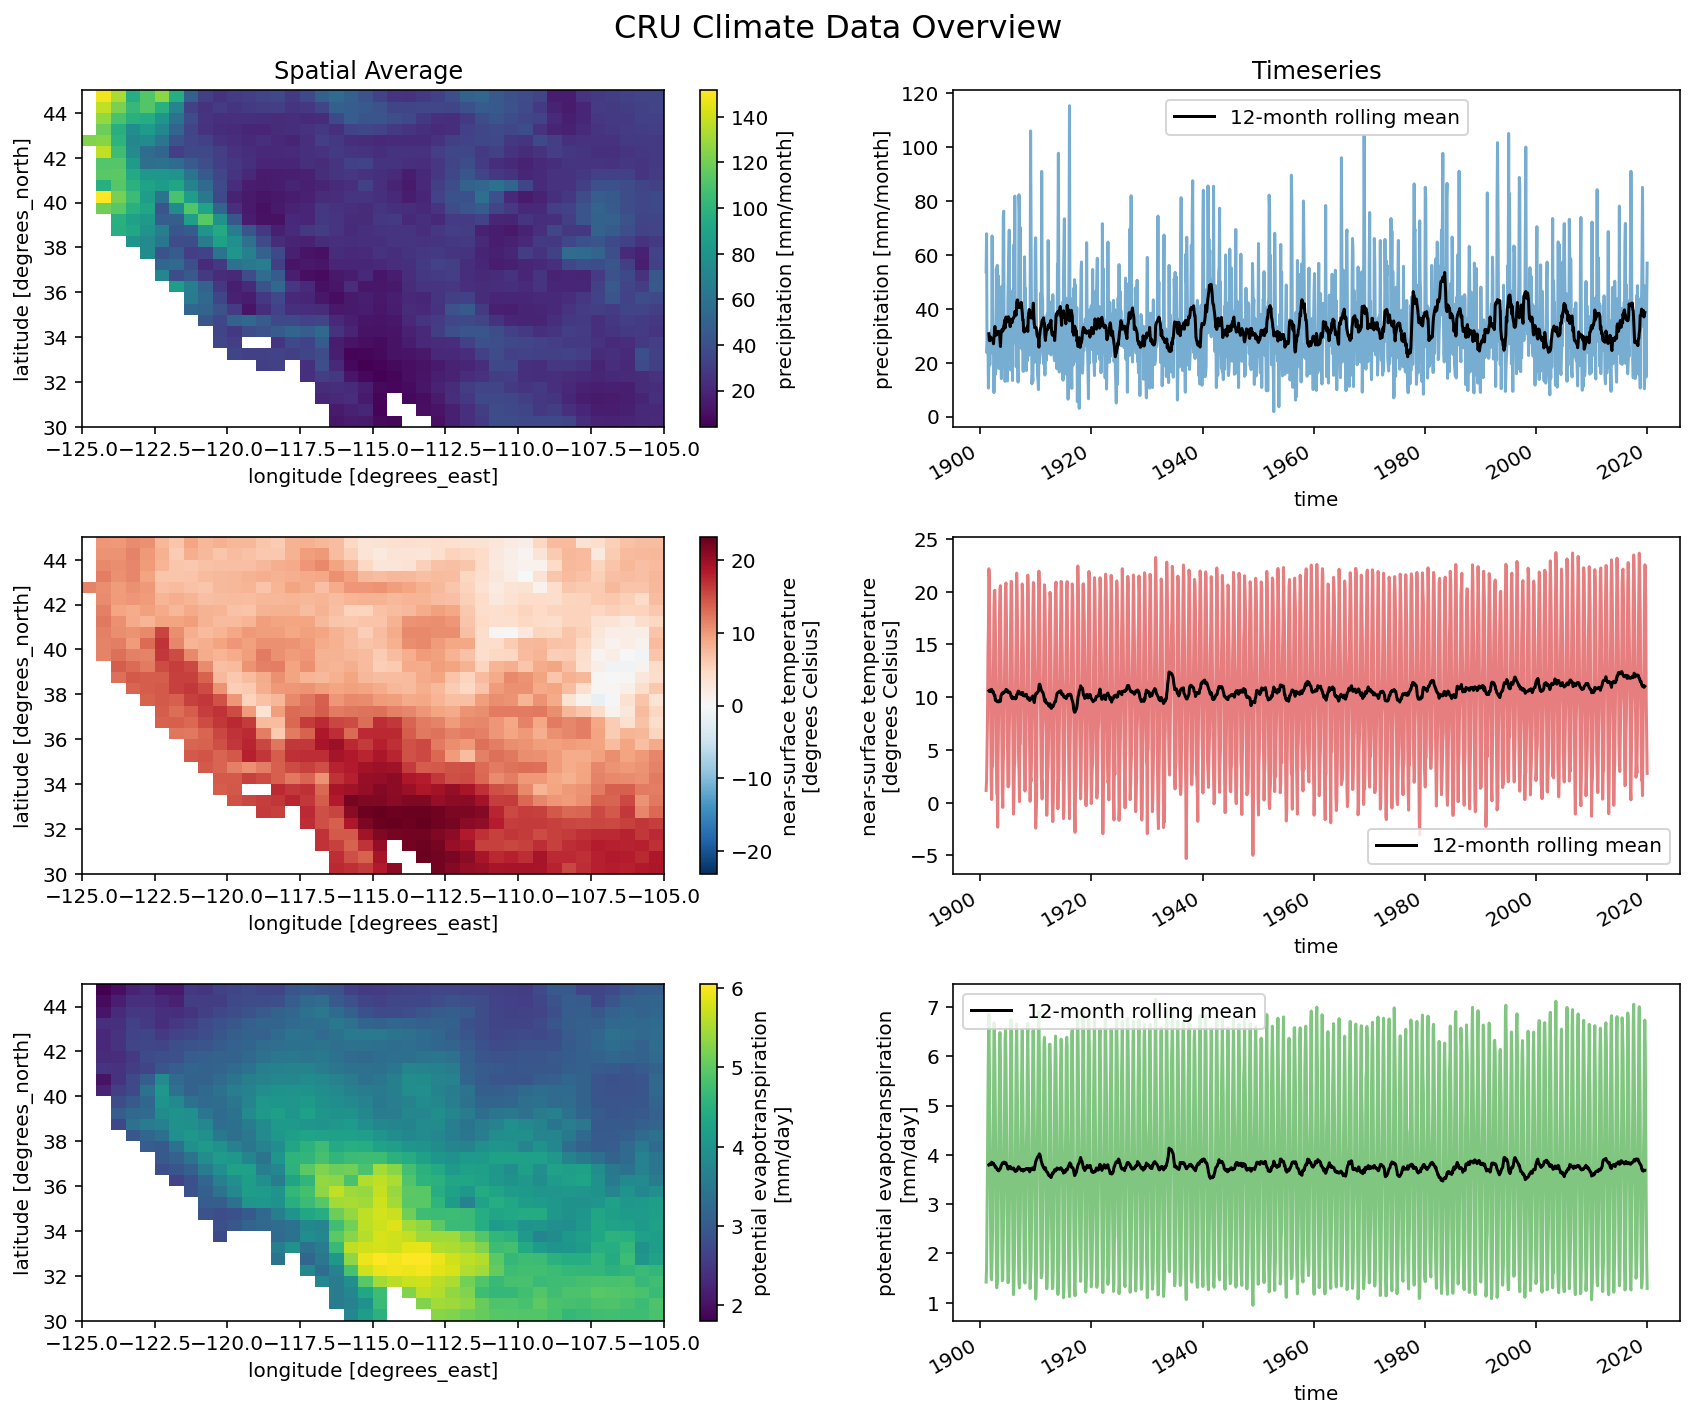

In [4]:
CRU_data_plot()
plt.suptitle('CRU Climate Data Overview', fontsize = 16)

n.b. The CRU Potential Evapotranspiration Data is in mm/day, I need it in mm/month to match with precip, so I'll sum it by month in the box model code.

# Bucket Model

In [5]:
class bucket:
    ''' one-box bucket model for soil moisture '''
    def __init__(self):
        """
        PARAMETERS:   TO DO FILL THIS OUT 
        Chang_I : Heat Index as defined in Chang et al. 2019
        Chang_ai_i : TK TK TK T
        """
        
        # Evapotranspiration 
        # Modified Thornwaithe EQ from Chang et al. 2019
        self.Chang_I = 41.47044637
        self.Chang_a_i = 6.75E-7*self.Chang_I**3 \
                         - 7.72E-5*self.Chang_I**2 \
                         + 1.7912E-2*self.Chang_I \
                         + 0.49239
        
        return None
    
    def bucket_integration(self, precip = pre_ds, 
                           SM_ini = 1, 
                           date_ini = '1901-01-16',
                           date_end = '2019-12-16',
                           tstep = 1, 
                           CRUpet = False,
                           tmx = tmx_ds, 
                           tmn = tmn_ds,
                           tmp = tmp_ds,
                           pet = pet_ds,
                           plotplots = True,
                           lat = [30,45], 
                           lon = [-125,-105],
                           bucket_depth = 400, # mm
                           crit = 290, wilt = 150 ): # crit and wilt default to silt loam soil 
        """ governing equation 
        
        PARAMETERS: TO DO FILL THIS OUT 
        
        
        """

        self.date_ini = date_ini
        self.date_end = date_end
        self.tstep = tstep
        
        date_params ={'time':[date_ini, date_end]}
        region_params = {'lat':lat, 'lon':lon}
        
        self.precip = precip.sel(lat=slice(*region_params['lat']), lon=slice(*region_params['lon']), time = slice(*date_params['time'])).mean(['lon','lat'], keep_attrs = True).pre
        self.tmx = tmx.sel(lat=slice(*region_params['lat']), lon=slice(*region_params['lon']), time=slice(*date_params['time'])).mean(['lon', 'lat'], keep_attrs = True).tmx
        self.tmn = tmn.sel(lat=slice(*region_params['lat']), lon=slice(*region_params['lon']), time=slice(*date_params['time'])).mean(['lon', 'lat'], keep_attrs = True).tmn 
        self.tmp = tmp.sel(lat=slice(*region_params['lat']), lon=slice(*region_params['lon']), time=slice(*date_params['time'])).mean(['lon', 'lat'], keep_attrs = True).tmp 
        self.pet = pet.sel(lat=slice(*region_params['lat']), lon=slice(*region_params['lon']), time=slice(*date_params['time'])).mean(['lon', 'lat'], keep_attrs = True).pet 

        
        self.crit = crit
        self.wilt = wilt
        
        central_lat = np.mean(lat)
        
        nsteps = int(len(pd.date_range(date_ini, date_end, freq="MS"))/tstep)
                
        SM = xr.Dataset(coords = {'time': (['time'],self.precip.time)}, 
                        data_vars = {'SM':(['time'],np.zeros(len((self.precip.time)))*np.nan)}, 
                        attrs = {'units': 'mm'})
        
        Epot_Calc = xr.Dataset(coords = {'time': (['time'], self.precip.time)}, 
                        data_vars = {'Epot':(['time'],np.zeros(len((self.precip.time)))*np.nan)}, 
                        attrs = {'units': 'mm/day'})
        
        SM.SM[0] = SM_ini
        
        for t in range(0, nsteps-1):

            dayOfYear = self.precip.time[t].dt.dayofyear 
            photoperiod = self.photo_calc(dayOfYear, central_lat)
            Epot_Calc.Epot[t] = self.PET_calculator(self.tmx[t], self.tmn[t], photoperiod)
            
            # convert Epot to mm/month by finding the number of days in the corresponding month
            days_in_month = self.precip.time.dt.days_in_month[t]

            # bucket integration equation
            
            # with model calculation of PET 
            if CRUpet == False:
                SM.SM[t+1] = (SM.SM[t]) + self.precip[t] - self.scaling_factor(SM.SM[t]) * days_in_month * Epot_Calc.Epot[t] 

            # with CRU EPOT data
            if CRUpet == True: 
                SM.SM[t+1] = (SM.SM[t]) + self.precip[t] - self.scaling_factor(SM.SM[t]) * days_in_month * self.pet[t]
            
            # bucket size
            if SM.SM[t+1] > bucket_depth:
                SM.SM[t+1] = bucket_depth
                
            # soil moisture level cannot be negative, so if it is less than 0 set to 0
            if SM.SM[t+1] < 0:
                SM.SM[t+1] = 0
        
        if SM.SM[0] == 1:
            SM.SM[0] = np.nan
            
        self.SM = SM
        self.Epot = Epot_Calc
        
        if plotplots == True:
            self.plot_timeseries()
        
        
        return self.SM, self.Epot
    
    
    def scaling_factor(self, theta):
        """ beta scaling factor for potential evapotransipration"""
        
        # wet regime
        if theta >= self.crit:
            beta = 1
        
        # dry regime
        if theta < self.wilt:
            beta = 0
        
        # scaling
        else:
            # Hunt 2009 SMI (don't think i want the +/- scaling bc the model is bottoming out )
            # beta = -5 + 10 * (theta - self.wilt)/(self.crit - self.wilt)
            
            # Seneviratne 2010
            beta = (theta - self.wilt)/(self.crit - self.wilt)
        return beta
        
    def PET_calculator(self, Tmax, Tmin, photoperiod):
        """ calculation of potential evapotranspiration using modified monthly thornthwaite equation from Chang et al. 2019"""
        
        # effective temperature
        Teff = 0.5 * 0.69 * (3*Tmax - Tmin)
        C = photoperiod/360.

        self.pet_calc = (C*(-415.85 + 32.24*Teff - 0.43*Teff**2) * (Teff >= 26) \
                    + 16.*C * (10.*Teff / self.Chang_I)**self.Chang_a_i \
                    * (Teff > 0) * (Teff < 26))
        
        return self.pet_calc
    
    def photo_calc(self, dayOfYear, lat):        
        latInRad = np.deg2rad(lat)
        declinationOfEarth = 23.45*np.sin(np.deg2rad(360.0*(283.0+dayOfYear)/365.0))
        if -np.tan(latInRad) * np.tan(np.deg2rad(declinationOfEarth)) <= -1.0:
            return 24.0
        elif -np.tan(latInRad) * np.tan(np.deg2rad(declinationOfEarth)) >= 1.0:
            return 0.0
        else:
            hourAngle = np.rad2deg(np.arccos(-np.tan(latInRad) * np.tan(np.deg2rad(declinationOfEarth))))
            return 2.0*hourAngle/15.0
        
    def plot_timeseries(self):
        """ simple plotting function """
        
        plt.figure(figsize=[10,8], tight_layout = True)
        self.SM.SM.plot(color = 'tab:brown', marker=".")
        plt.xlabel('years')
        plt.ylabel('soil moisture [mm/]')
        plt.grid()
         
        return None

In [6]:
model = bucket()

In [7]:
# model run over entire time series, using calculated evapotranspiration, this will take a while as the dataset is over the entire 21st century
# soil_moisture, Epot_Calc = model.bucket_integration(CRUpet = False)

## Evaluating Potential Evapotranspiration Calculation

First over the entire CRU data timeseries: 

Pearson's Correlation Coefficient:  0.9921447456191961
Mean difference:  0.5831183945815063


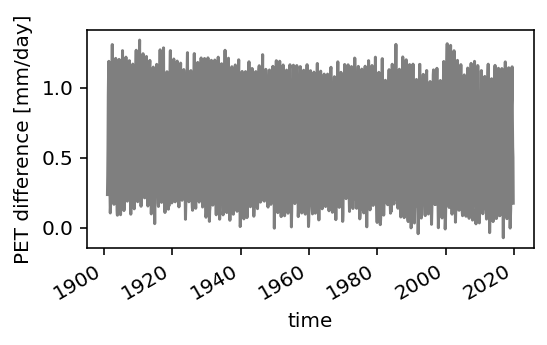

In [8]:
# n.b. Epot_Calc will be my calculation of potential evapotranspiration regardless of CRUpet call
SM_CRU, Epot_Calc = model.bucket_integration(CRUpet = True, plotplots = False)

# Calculate Pearson's Correlation Coefficient 
print("Pearson's Correlation Coefficient: ", xr.corr(Epot_Calc.Epot, pet_ds.pet.mean(['lon', 'lat'], keep_attrs = True)).data)

# Calculate Difference 
difference = pet_ds.pet.mean(['lon', 'lat'], keep_attrs = True) - Epot_Calc.Epot
difference.plot(figsize = (4, 2), color = 'tab:grey')
plt.ylabel("PET difference [mm/day]")
print("Mean difference: ", difference.mean().data)

Then over a smaller sub-region, in this case Northern California between January 2014 and December 2019. 

Pearson's Correlation Coefficient:  0.9916893430883262
Mean difference:  0.16804114417574764


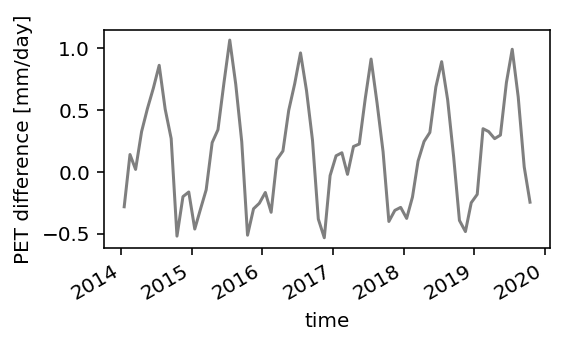

In [9]:
date_ini = '2014-1'
date_end = '2019-12-16'
date_params = {'time': [date_ini, date_end]}

# northern california
region_params = {'lat':[40,42], 'lon':[-124, -120]}

# n.b. Epot_Calc will be my calculation of potential evapotranspiration regardless of CRUpet call
SM_CRU, Epot_Calc = model.bucket_integration(CRUpet = True, plotplots = False, lat = region_params['lat'], lon = region_params['lon'])

# select CRU_pet over the appropriate time series
CRU_pet = pet_ds.sel(lat=slice(*region_params['lat']), lon=slice(*region_params['lon']), time=slice(*date_params['time'])).pet.mean(['lon','lat'])

# select Epot_Calc over the appropriate timeseries
Epot_Calc = Epot_Calc.sel(time=slice(*date_params['time']))

# Calculate Pearson's Correlation Coefficient 
print("Pearson's Correlation Coefficient: ", xr.corr(Epot_Calc.Epot, CRU_pet).data)

# Calculate Difference 
difference = CRU_pet - Epot_Calc.Epot
difference.plot(figsize = (4, 2), color = 'tab:grey')
plt.ylabel("PET difference [mm/day]")
print("Mean difference: ", difference.mean().data)

# Summer Soil Moisture Anomalies

In [10]:
date_ini = '1901-1'
date_end = '2019-12'
date_params = {'time': [date_ini, date_end]}

# california region
region_params = {'lat':[32,42], 'lon':[-125, -116]}

# california region
SM, Epot_Calc = model.bucket_integration(CRUpet = False, plotplots = False, date_ini = date_ini, date_end = date_end, lat = region_params['lat'], lon = region_params['lon'])

# full south west
#SM, Epot_Calc = model.bucket_integration(CRUpet = False, plotplots = False, date_ini = date_ini, date_end = date_end)

(-24837.0, 18262.0)

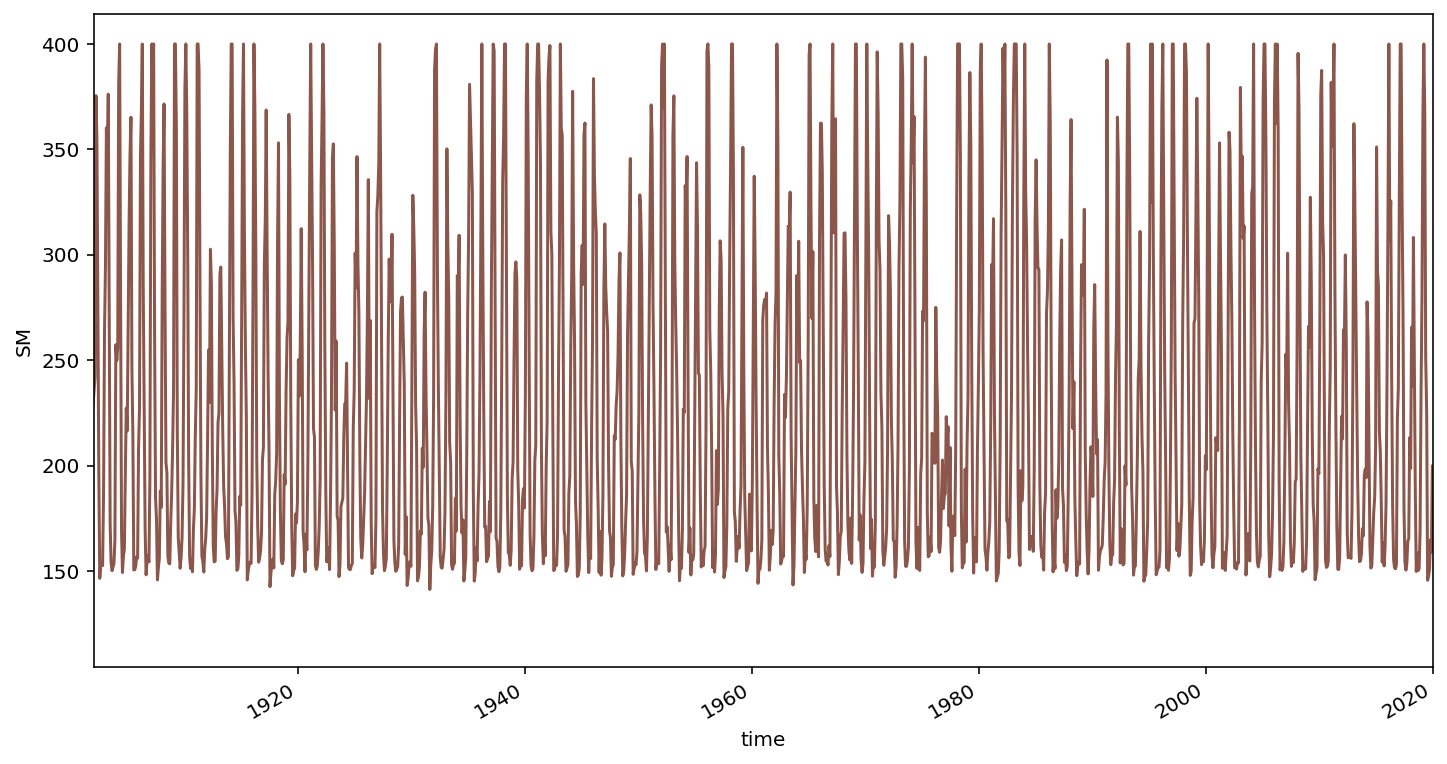

In [11]:
SM.SM.plot(color = 'tab:brown')
plt.xlim(['1902','2020'])


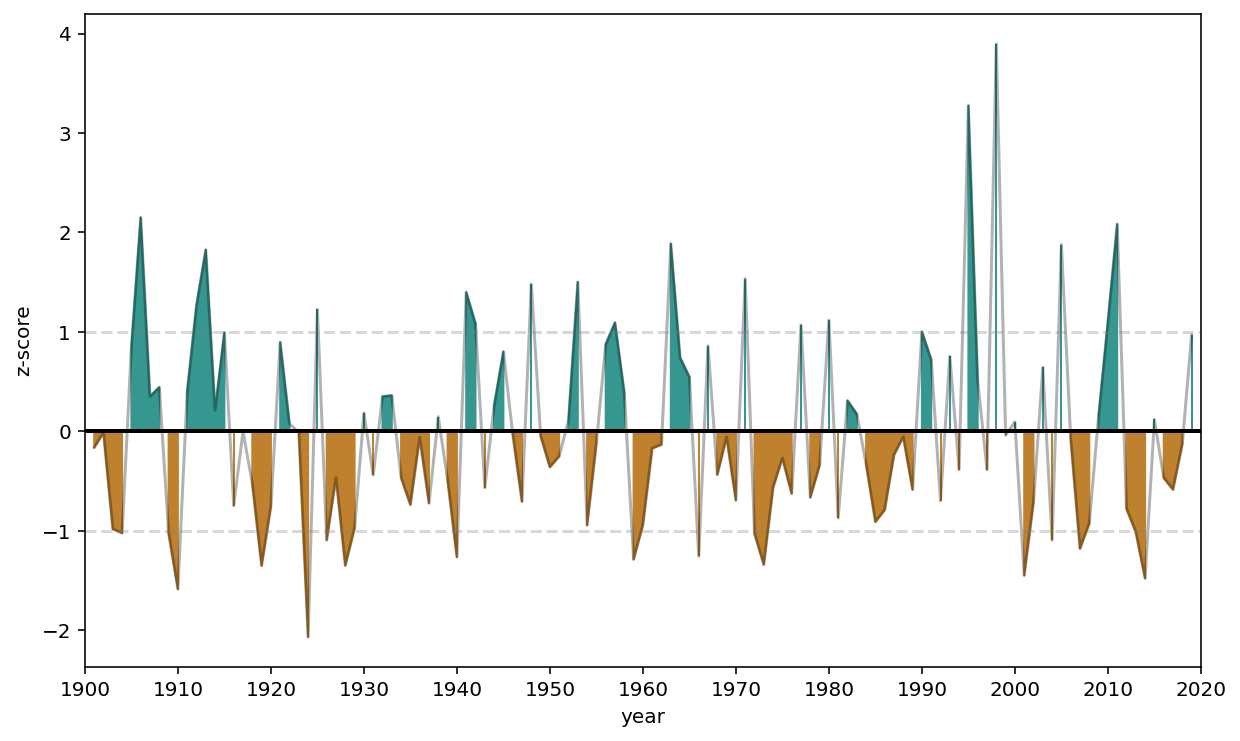

In [12]:
plt.figure(figsize = (10, 6))
Summer_SM_means = SM.SM.isel(time=SM.SM.groupby('time.season').groups['JJA']).groupby('time.year').mean()

Summer_Anoms = (Summer_SM_means - Summer_SM_means.mean())/Summer_SM_means.std()
Summer_Anoms.plot(color = 'k', alpha = 0.3)

# Shading
#i_neg=pdsi_series.copy(); i_neg[np.where(i_neg>=0)]=0; i_neg[np.where(i_neg<0)]=1
#i_pos=pdsi_series.copy(); i_pos[np.where(i_neg==0)]=1; i_pos[np.where(i_neg==1)]=0
i_neg = (Summer_Anoms < 0)
i_pos = (Summer_Anoms > 0)

# Plot time series
#plt.fill_between(yrs_trim, y_zeros, pdsi_series, where=i_neg, color='#bf812d', alpha=1)
#plt.fill_between(yrs_trim, y_zeros, pdsi_series, where=i_pos, color='#35978f', alpha=1)
plt.fill_between(Summer_Anoms.year, Summer_Anoms.data, where = i_neg, color = '#bf812d')
plt.fill_between(Summer_Anoms.year, Summer_Anoms.data, where = i_pos, color = '#35978f')


# 0 Line
plt.axhline(y = 0, color='k', linestyle='-', linewidth = 2)
plt.axhline(y = 1, color='grey', linestyle='--', alpha = 0.3)
plt.axhline(y = -1, color='grey', linestyle='--', alpha = 0.3)

plt.ylabel('z-score')
plt.xlim([1901,2019])
plt.xticks([1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020]);

plt.savefig('figures/california-region-anomalies.png', dpi = 300)
#plt.savefig('figures/southwest-anomalies.png', dpi = 300)

## B-factor sensitivity tests

Run through all the soil types


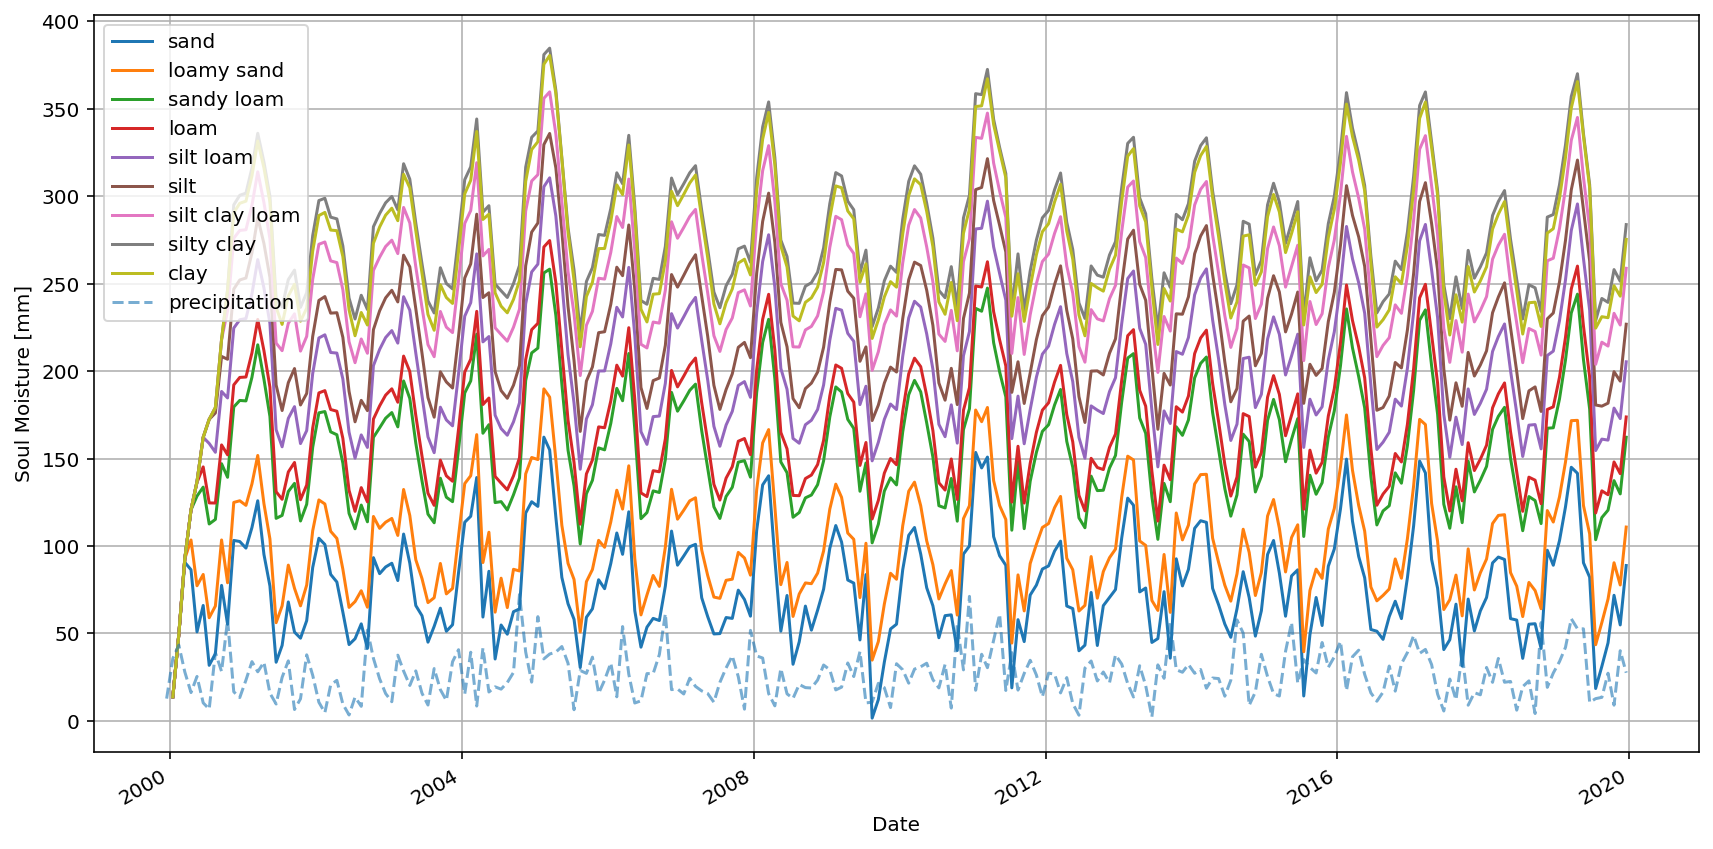

In [24]:
# i know this should be a dictionary or xarray of xarrays.... ran out of time

date_ini = '1999-12'
date_end = '2019-12'
date_params = {'time': [date_ini, date_end]}

# Utah Region
region_params = {'lat':[37,42], 'lon':[-114, -109]}

# California Region
# region_params = {'lat':[32,42], 'lon':[-125, -116]}


sand_SM, Epot = model.bucket_integration(crit = 120, wilt = 45, 
                                         date_ini = date_ini, date_end = date_end, 
                                         lat = region_params['lat'], lon = region_params['lon'], 
                                         plotplots = False)

loamy_sand_SM, Epot = model.bucket_integration(crit = 150, wilt = 65, 
                                         date_ini = date_ini, date_end = date_end, 
                                         lat = region_params['lat'], lon = region_params['lon'], 
                                         plotplots = False)

sandy_loam_SM, Epot = model.bucket_integration(crit = 230, wilt = 110, 
                                         date_ini = date_ini, date_end = date_end, 
                                         lat = region_params['lat'], lon = region_params['lon'], 
                                         plotplots = False)

loam_SM, Epot = model.bucket_integration(crit = 250, wilt = 120, 
                                         date_ini = date_ini, date_end = date_end, 
                                         lat = region_params['lat'], lon = region_params['lon'], 
                                         plotplots = False)

silt_loam_SM, Epot = model.bucket_integration(crit = 290, wilt = 150, 
                                         date_ini = date_ini, date_end = date_end, 
                                         lat = region_params['lat'], lon = region_params['lon'], 
                                         plotplots = False)

silt_SM, Epot = model.bucket_integration(crit = 320, wilt = 170, 
                                         date_ini = date_ini, date_end = date_end, 
                                         lat = region_params['lat'], lon = region_params['lon'], 
                                         plotplots = False)

silt_clay_loam_SM, Epot = model.bucket_integration(crit = 335, wilt = 205, 
                                         date_ini = date_ini, date_end = date_end, 
                                         lat = region_params['lat'], lon = region_params['lon'], 
                                         plotplots = False)

silty_clay_SM, Epot = model.bucket_integration(crit = 360, wilt = 230, 
                                         date_ini = date_ini, date_end = date_end, 
                                         lat = region_params['lat'], lon = region_params['lon'], 
                                         plotplots = False)

clay_SM, Epot = model.bucket_integration(crit = 360, wilt = 220, 
                                         date_ini = date_ini, date_end = date_end, 
                                         lat = region_params['lat'], lon = region_params['lon'], 
                                         plotplots = False)



plt.figure(tight_layout = True)

sand_SM.SM.plot(label = 'sand')
loamy_sand_SM.SM.plot(label = 'loamy sand')
sandy_loam_SM.SM.plot(label = 'sandy loam')
loam_SM.SM.plot(label = 'loam')
silt_loam_SM.SM.plot(label = 'silt loam')
silt_SM.SM.plot(label = 'silt')
silt_clay_loam_SM.SM.plot(label = 'silt clay loam')
silty_clay_SM.SM.plot(label = 'silty clay')
clay_SM.SM.plot(label = 'clay')

pre_ds.sel(lat=slice(*region_params['lat']), lon=slice(*region_params['lon']), time=slice(*date_params['time'])).mean(['lon', 'lat'], keep_attrs = True).pre.plot(color = 'tab:blue', linestyle = '--', alpha = 0.6, label = 'precipitation')



plt.legend()
plt.ylabel("Soul Moisture [mm]")
plt.xlabel("Year")
plt.grid()

plt.savefig('figures/soil-types-utah-region-2000-2019.png', dpi = 300)
#plt.savefig('figures/soil-types-california-region-2000-2019.png', dpi = 300)

In [26]:
clay_SM.SM.mean()

<xarray.DataArray 'SM' ()>
array(269.24024677)

In [27]:
sand_SM.SM.mean()

<xarray.DataArray 'SM' ()>
array(76.53163497)

# Identifying Historic Droughts

## 2014 California Drought

Region: 

Time Period: 
Drought during TK to TK with two years prior to see seasonality


- $\theta_{crit} = 120$
- $\theta_{wilt} = 250$

US Drought Monitor: https://www.drought.gov/historical-information?state=california&dataset=0&selectedDateUSDM=20130917

California Drought Year zoom Index: 

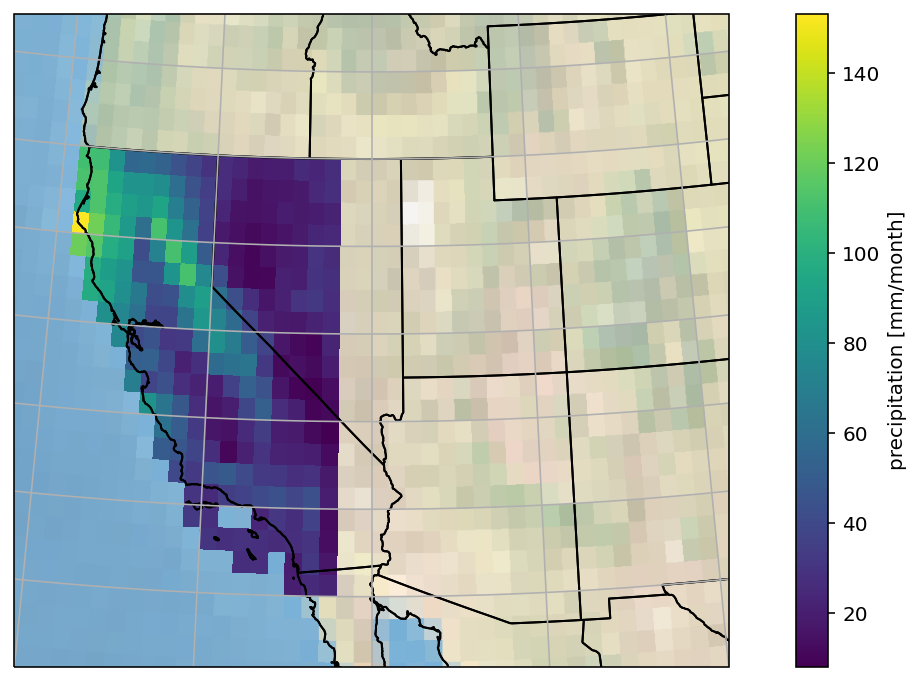

In [14]:

wilt = 120
crit = 250

# california and some of nevada
region_params = {'lat':[32,42], 'lon':[-125, -116]}

import cartopy.crs as ccrs
import cartopy

extent = [-125, -105, 30, 45]
# exact center
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

plt.figure()
ax = plt.axes(projection = ccrs.AlbersEqualArea(central_lon, central_lat))
ax.set_extent(extent)

ax.add_feature(cartopy.feature.STATES)
ax.coastlines()
ax.gridlines()
ax.stock_img()

pre_ds.sel(lat=slice(*region_params['lat']), lon=slice(*region_params['lon']), time=slice(*date_params['time'])).mean('time', keep_attrs = True).pre.plot(transform = ccrs.PlateCarree())

SM_cali, Epot_Calc = model.bucket_integration(CRUpet = False, lat = region_params['lat'], lon = region_params['lon'], 
                                              wilt = wilt, crit = crit, plotplots = False)

plt.savefig('figures/california_region.png', dpi = 300)

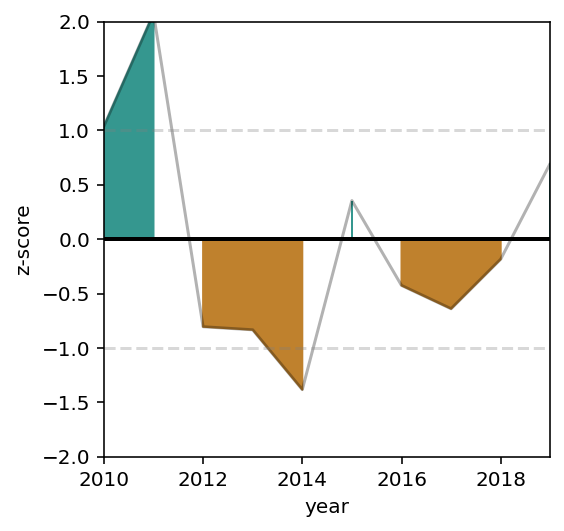

In [15]:
#SM, Epot_Calc = model.bucket_integration(CRUpet = False, plotplots = False, lat = region_params['lat'], lon = region_params['lon'])

SM = SM_cali

plt.figure(figsize = (4, 4))
Summer_SM_means = SM.SM.isel(time=SM.SM.groupby('time.season').groups['JJA']).groupby('time.year').mean()

Summer_Anoms = (Summer_SM_means - Summer_SM_means.mean())/Summer_SM_means.std()
Summer_Anoms.plot(color = 'k', alpha = 0.3)

# Shading
i_neg = (Summer_Anoms < 0)
i_pos = (Summer_Anoms > 0)

# Plot time series
plt.fill_between(Summer_Anoms.year, Summer_Anoms.data, where = i_neg, color = '#bf812d')
plt.fill_between(Summer_Anoms.year, Summer_Anoms.data, where = i_pos, color = '#35978f')


# 0 Line
plt.axhline(y = 0, color='k', linestyle='-', linewidth = 2)
plt.axhline(y = 1, color='grey', linestyle='--', alpha = 0.3)
plt.axhline(y = -1, color='grey', linestyle='--', alpha = 0.3)

plt.ylabel('z-score')
plt.xlim([2010,2019])
plt.ylim([-2,2])
#plt.xticks([1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020]);

#plt.savefig('figures/california-region-anomalies.png', dpi = 300)
#plt.savefig('figures/southwest-anomalies.png', dpi = 300)
plt.savefig('figures/california-2014-drought-index.png', dpi = 300)

In [16]:
# just major drought year
SM_cali_2014 = SM_cali.isel(time = SM_cali.time.dt.year == 2014)
SM_cali_20092019 = SM_cali.sel(time = slice ('2009-01-01', '2019-12-31'))

In [17]:
cali_max = SM_cali.SM.groupby('time.month').max()
cali_min = SM_cali.SM.groupby('time.month').min()

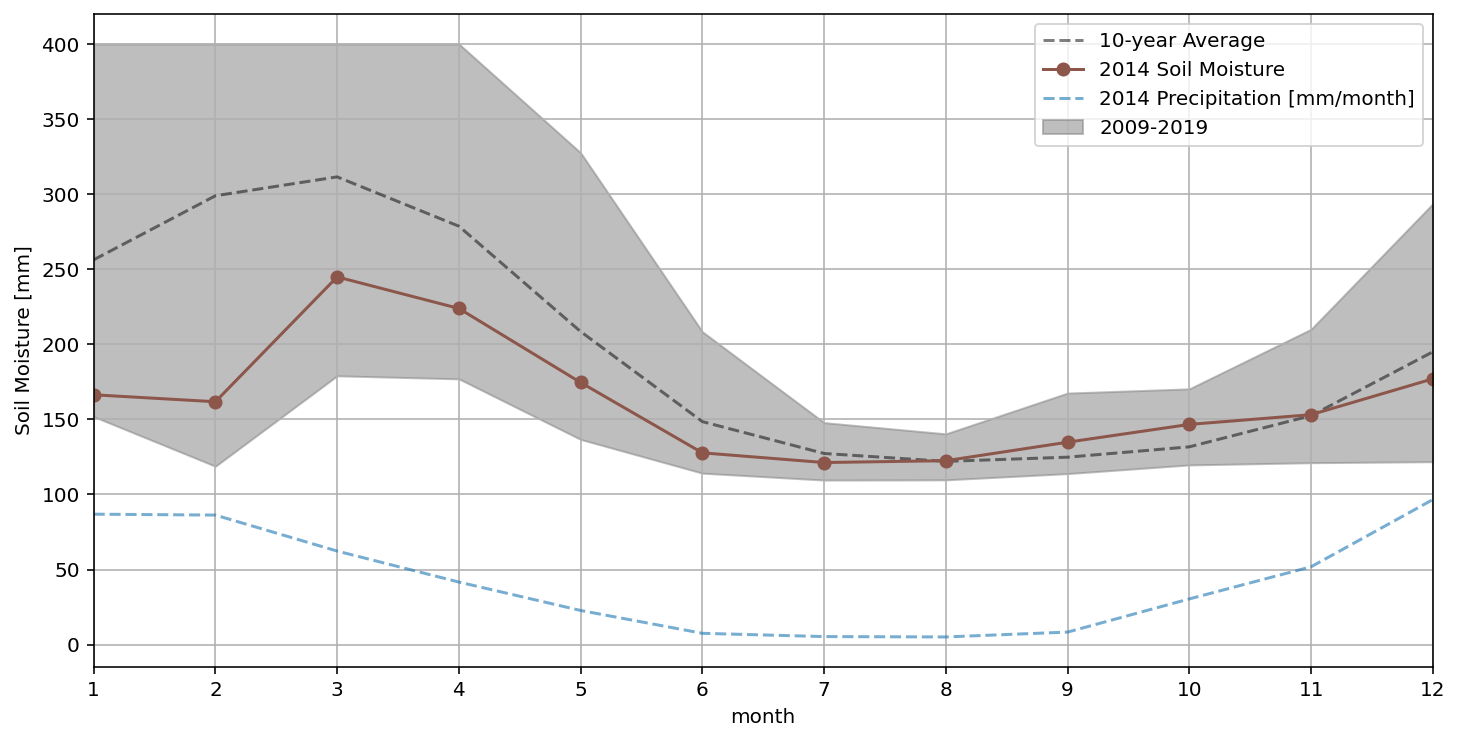

In [18]:
plt.figure()

plt.fill_between(cali_min.month, cali_max, cali_min, color = 'tab:grey', alpha = 0.5, label = '2009-2019')
SM_cali.SM.groupby('time.month').mean().plot(linestyle = '--', alpha = 0.5, color = 'black', label = '10-year Average')
SM_cali_2014.SM.groupby('time.month').mean().plot(marker = 'o', color = 'tab:brown', label = '2014 Soil Moisture')

pre_ds.sel(lat=slice(*region_params['lat']), 
           lon=slice(*region_params['lon']), 
           time=slice(*date_params['time'])).mean(['lon', 'lat'], keep_attrs = True).pre.groupby('time.month').mean().plot(color = 'tab:blue', 
                                                                                                                           linestyle = '--', alpha = 0.6, 
                                                                                                                           label = '2014 Precipitation [mm/month]')


plt.xlim([1,12])
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])
plt.ylabel('Soil Moisture [mm]')
plt.grid()
plt.legend()

plt.savefig('figures/california-2014-drought.png', dpi = 300)

## Utah 2002

Region: Utah {'lat':[37,42], 'lon':[-114, -109]}

Time Period: Severe Drought in 2002, looking at 10 year time period around

Soil type: 

- $\theta_{crit} = $ ~150
- $\theta_{wilt} = $ ~ 65

US Drought Monitor: https://www.drought.gov/historical-information?state=utah&dataset=0&selectedDateUSDM=20030610 

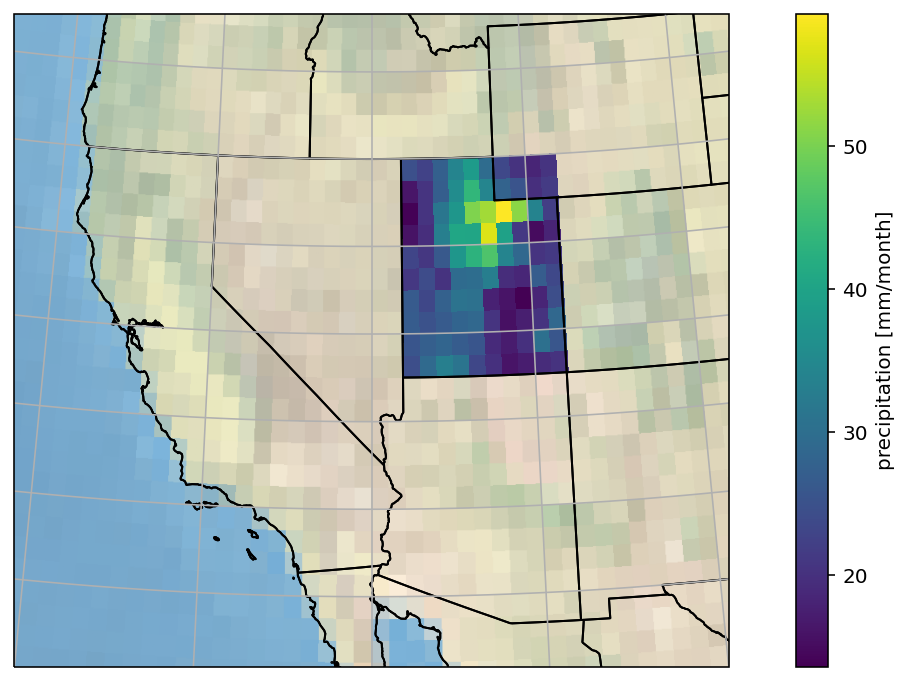

In [19]:
# utah
region_params = {'lat':[37,42], 'lon':[-114, -109]}

wilt = 65
crit = 150 #loamy sand

import cartopy.crs as ccrs
import cartopy

extent = [-125, -105, 30, 45]
# exact center
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

plt.figure()
ax = plt.axes(projection = ccrs.AlbersEqualArea(central_lon, central_lat))
ax.set_extent(extent)

ax.add_feature(cartopy.feature.STATES)
ax.coastlines()
ax.gridlines()
ax.stock_img()

pre_ds.sel(lat=slice(*region_params['lat']), lon=slice(*region_params['lon'])).mean('time', keep_attrs = True).pre.plot(transform = ccrs.PlateCarree())

SM_utah, Epot_Calc = model.bucket_integration(CRUpet = False, 
                                              lat = region_params['lat'], lon = region_params['lon'],       
                                              wilt = wilt, crit = crit, 
                                              plotplots = False)

plt.savefig('figures/utah.png', dpi = 300)

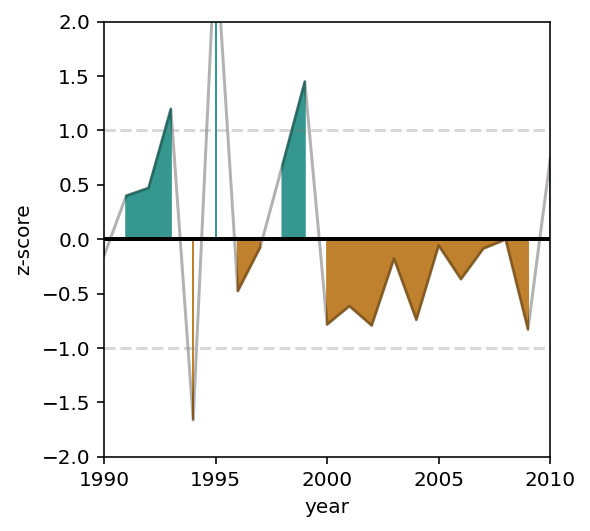

In [20]:
#SM, Epot_Calc = model.bucket_integration(CRUpet = False, plotplots = False, wilt = wilt, crit = crit, lat = region_params['lat'], lon = region_params['lon'])
SM = SM_utah

plt.figure(figsize = (4, 4))
Summer_SM_means = SM.SM.isel(time=SM.SM.groupby('time.season').groups['JJA']).groupby('time.year').mean()

Summer_Anoms = (Summer_SM_means - Summer_SM_means.mean())/Summer_SM_means.std()
Summer_Anoms.plot(color = 'k', alpha = 0.3)

# Shading
i_neg = (Summer_Anoms < 0)
i_pos = (Summer_Anoms > 0)

# Plot time series
plt.fill_between(Summer_Anoms.year, Summer_Anoms.data, where = i_neg, color = '#bf812d')
plt.fill_between(Summer_Anoms.year, Summer_Anoms.data, where = i_pos, color = '#35978f')


# 0 Line
plt.axhline(y = 0, color='k', linestyle='-', linewidth = 2)
plt.axhline(y = 1, color='grey', linestyle='--', alpha = 0.3)
plt.axhline(y = -1, color='grey', linestyle='--', alpha = 0.3)

plt.ylabel('z-score')
plt.xlim([1990,2010])
plt.ylim([-2,2])
#plt.xticks([1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020]);


plt.savefig('figures/utah-2003-drought-index.png', dpi = 300)

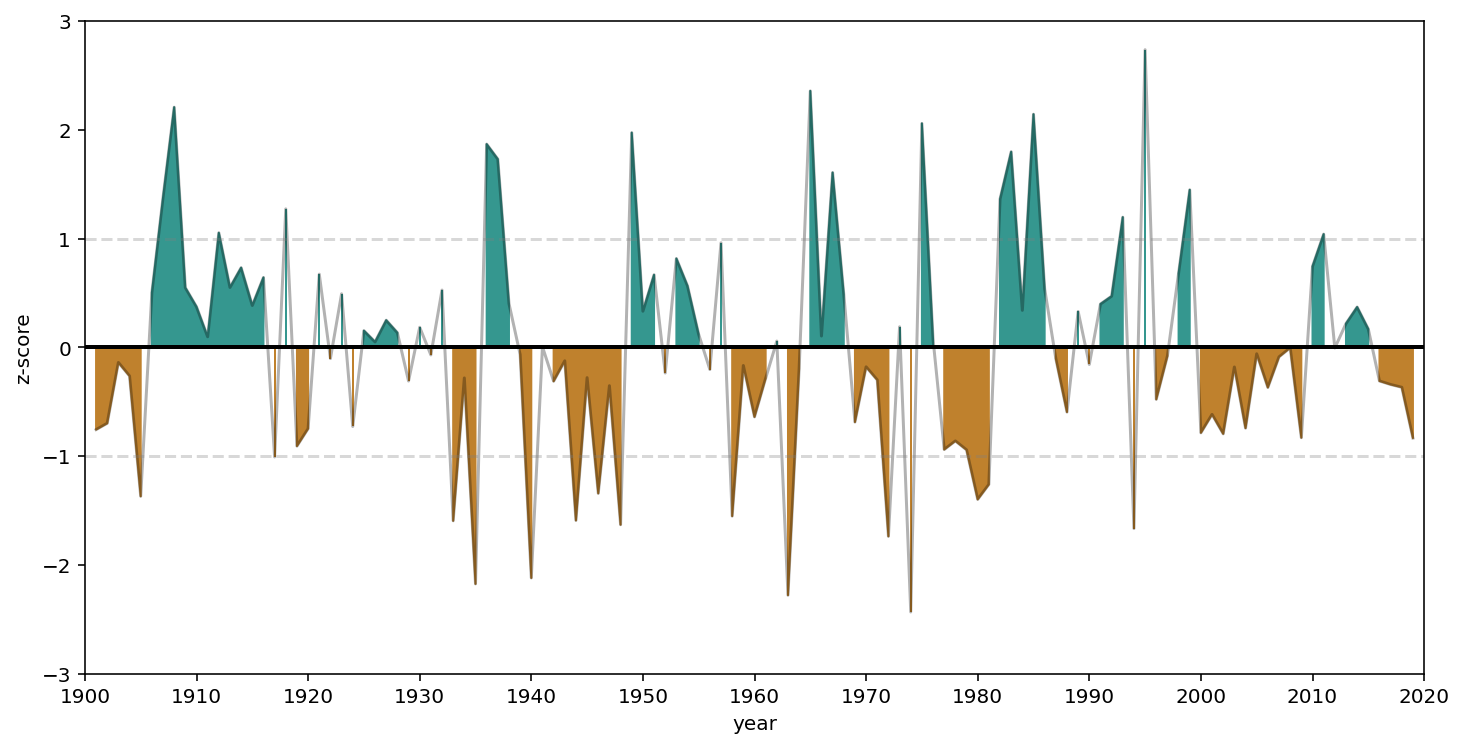

In [49]:
SM = SM_utah

#plt.figure(figsize = (4, 4))
Summer_SM_means = SM.SM.isel(time=SM.SM.groupby('time.season').groups['JJA']).groupby('time.year').mean()

Summer_Anoms = (Summer_SM_means - Summer_SM_means.mean())/Summer_SM_means.std()
Summer_Anoms.plot(color = 'k', alpha = 0.3)

# Shading
i_neg = (Summer_Anoms < 0)
i_pos = (Summer_Anoms > 0)

# Plot time series
plt.fill_between(Summer_Anoms.year, Summer_Anoms.data, where = i_neg, color = '#bf812d')
plt.fill_between(Summer_Anoms.year, Summer_Anoms.data, where = i_pos, color = '#35978f')


# 0 Line
plt.axhline(y = 0, color='k', linestyle='-', linewidth = 2)
plt.axhline(y = 1, color='grey', linestyle='--', alpha = 0.3)
plt.axhline(y = -1, color='grey', linestyle='--', alpha = 0.3)

plt.ylabel('z-score')
plt.xlim([1990,2010])
plt.ylim([-3,3])
plt.xticks([1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020]);


plt.savefig('figures/utah-drought-index.png', dpi = 300)

In [50]:
Summer_Anoms.isel(year=(Summer_Anoms.year == 2002))
Summer_Anoms.isel(year=(Summer_Anoms.year == 1992))


<xarray.DataArray 'SM' (year: 1)>
array([0.47152124])
Coordinates:
  * year     (year) int64 1992

In [28]:
SM_utah_20002010 = SM_utah.sel(time=slice('2000-01-01','2010-12-31'))
SM_utah_2002 = SM_utah.isel(time=(SM_utah.time.dt.year==2002))

In [29]:
utah_max = SM_utah_20002010.SM.groupby('time.month').max()
utah_min = SM_utah_20002010.SM.groupby('time.month').min()

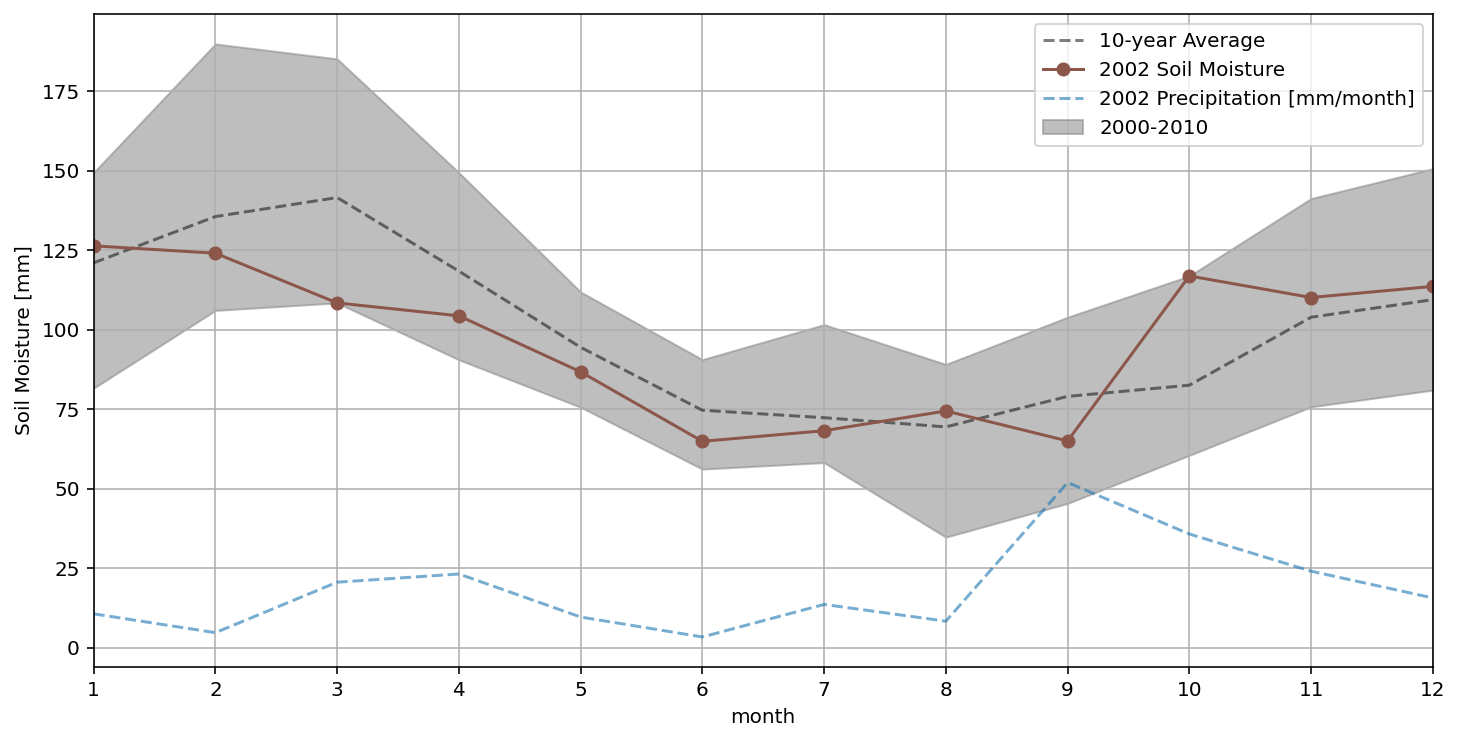

In [30]:
date_params_2002 = {'time': ['2002-01', '2002-12']}

plt.figure()

plt.fill_between(utah_min.month, utah_max, utah_min, color = 'tab:grey', alpha = 0.5, label = '2000-2010')
SM_utah_20002010.SM.groupby('time.month').mean().plot(linestyle = '--', alpha = 0.5, color = 'black', label = '10-year Average')
SM_utah_2002.SM.groupby('time.month').mean().plot(marker = 'o', color = 'tab:brown', label = '2002 Soil Moisture')

pre_ds.sel(lat=slice(*region_params['lat']), 
           lon=slice(*region_params['lon']), 
           time=slice(*date_params_2002['time'])).mean(['lon', 'lat'], keep_attrs = True).pre.groupby('time.month').mean().plot(color = 'tab:blue', linestyle = '--', alpha = 0.6, label = '2002 Precipitation [mm/month]')

plt.xlim([1,12])
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])
plt.ylabel('Soil Moisture [mm]')
plt.grid()
plt.legend()

plt.savefig('figures/utah-2003-drought.png', dpi = 300)

### Works Cited

Chang, X., Wang, S., Gao, Z., Luo, Y., & Chen, H. (2019). Forecast of Daily Reference Evapotranspiration Using a Modified Daily Thornthwaite Equation and Temperature Forecasts†. Irrigation and Drainage, 68(2), 297–317. https://doi.org/10.1002/ird.2309

Seneviratne, S. I., Corti, T., Davin, E. L., Hirschi, M., Jaeger, E. B., Lehner, I., et al. (2010). Investigating soil moisture–climate interactions in a changing climate: A review. Earth-Science Reviews, 99(3), 125–161. https://doi.org/10.1016/j.earscirev.2010.02.004

Sridhar, V., Hubbard, K. G., You, J., & Hunt, E. D. (2008). Development of the Soil Moisture Index to Quantify Agricultural Drought and Its “User Friendliness” in Severity-Area-Duration Assessment. Journal of Hydrometeorology, 9(4), 660–676. https://doi.org/10.1175/2007JHM892.1

Thornthwaite, C. W. (1948). An Approach toward a Rational Classification of Climate. Geographical Review, 38(1), 55–94. https://doi.org/10.2307/210739